[DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) is likely the most sophisticated differential equation solver suite available in any language.  There are more than 200 methods implemented that are capable of solving all types of differential equations including

 * Discrete equations (function maps, discrete stochastic (Gillespie/Markov) simulations)
 * Ordinary differential equations (ODEs)
 * Split and Partitioned ODEs (Symplectic integrators, IMEX Methods)
 * Stochastic ordinary differential equations (SODEs or SDEs)
 * Stochastic differential-algebraic equations (SDAEs)
 * Random differential equations (RODEs or RDEs)
 * Differential algebraic equations (DAEs)
 * Delay differential equations (DDEs)
 * Neutral, retarded, and algebraic delay differential equations (NDDEs, RDDEs, and DDAEs)
 * Stochastic delay differential equations (SDDEs)
 * Experimental support for stochastic neutral, retarded, and algebraic delay differential equations (SNDDEs, SRDDEs, and SDDAEs)
 * Mixed discrete and continuous equations (Hybrid Equations, Jump Diffusions)
 * (Stochastic) partial differential equations ((S)PDEs) (with both finite difference and finite element methods)
 
See [documentation](https://diffeq.sciml.ai/stable/) for more.

# Install

[DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) is not installed by default when Julia is installed.  To ensure it's installed, either run

```julia
using Pkg; Pkg.add("DifferentialEquations")
```

from the Julia REPL or enter the package manager with `]` and then run

```julia
add DifferentialEquations
```

# Example - Robertson Equations

\begin{align}
\frac{dy_1}{dt} &= -0.04y_1 + 10^4 y_2 y_3 \\
\frac{dy_2}{dt} &=  0.04y_1 - 10^4 y_2 y_3 - 3 * 10^7 y_2^2 \\
\frac{dy_3}{dt} &=  3 * 10^7 y_2^2
\end{align}

Define the system of equations.

In [2]:
function rober!(du,u,p,t)
  y₁,y₂,y₃ = u
  k₁,k₂,k₃ = p
  du[1] = -k₁*y₁+k₃*y₂*y₃
  du[2] =  k₁*y₁-k₂*y₂^2-k₃*y₂*y₃
  du[3] =  k₂*y₂^2
  nothing
end

rober! (generic function with 1 method)

Define the ODE problem.

In [3]:
using DifferentialEquations

u₀ = [1.0,0.0,0.0]
tspan = (0.0,1e5)
params = [0.04,3e7,1e4]

ode_prob = ODEProblem(rober!,u₀,tspan,params);

Solve and plot

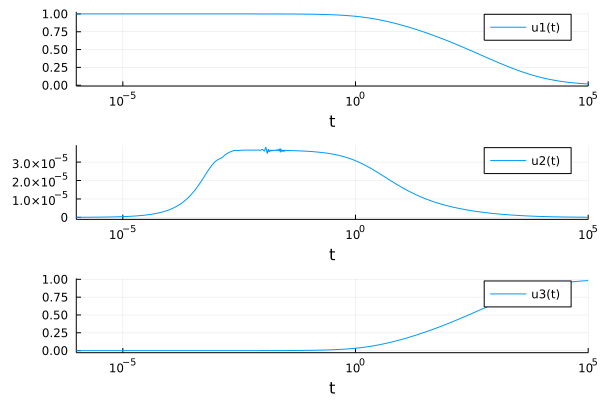

In [4]:
using Plots

ode_sol = solve(ode_prob)
plot(ode_sol, tspan=(1e-6,1e5), xscale=:log10, layout=(3,1))

## User defined Jacobian

The Jacobian $J$ of a function $f(\mathbf{x})$ is

$$
J_{ij} = \frac{\partial f(\mathbf{x})_i}{\partial x_j}
$$

In [5]:
function rober_jac!(J,u,p,t)
  y₁,y₂,y₃ = u
  k₁,k₂,k₃ = p
  J[1,1] = k₁ * -1
  J[2,1] = k₁
  J[3,1] = 0
  J[1,2] = y₃ * k₃
  J[2,2] = y₂ * k₂ * -2 + y₃ * k₃ * -1
  J[3,2] = y₂ * 2 * k₂
  J[1,3] = k₃ * y₂
  J[2,3] = k₃ * y₂ * -1
  J[3,3] = 0
  nothing
end

rober_jac! (generic function with 1 method)

Define the function and problem

In [6]:
ode_fun_jac = ODEFunction(rober!, jac=rober_jac!)
ode_prob_jac = ODEProblem(ode_fun_jac, u₀, tspan, params);

Solve and plot, this time specifying the solver.

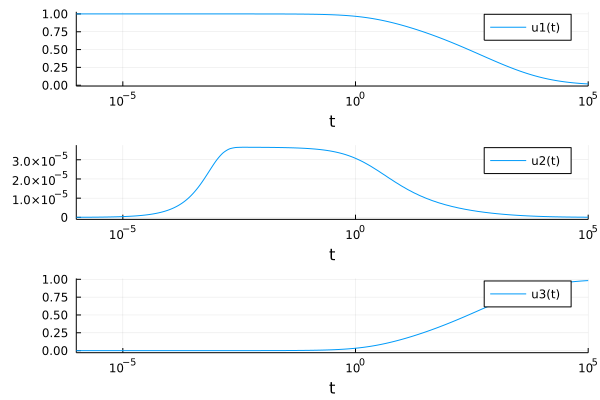

In [7]:
ode_sol_jac = solve(ode_prob_jac, Rosenbrock23())
plot(ode_sol_jac, tspan=(1e-6,1e5), xscale=:log10, layout=(3,1))

Benchmark the two solves.

In [28]:
using BenchmarkTools;

@btime solve(ode_prob, Rosenbrock23());
@btime solve(ode_prob_jac, Rosenbrock23());

  63.500 μs (438 allocations: 38.41 KiB)
  56.593 μs (355 allocations: 32.34 KiB)


## Automatic differentiation Jacobian

In [9]:
using ForwardDiff

function rober_jac_auto!(J,u,p,t)
  out = zero(u)
  ForwardDiff.jacobian!(J, (y, x) -> rober!(y, x, p, t), out, u) 
  nothing
end

rober_jac_auto! (generic function with 1 method)

In [10]:
ode_fun_ad_jac = ODEFunction(rober!, jac=rober_jac_auto!)
ode_prob_ad_jac = ODEProblem(ode_fun_ad_jac, u₀, tspan, params);

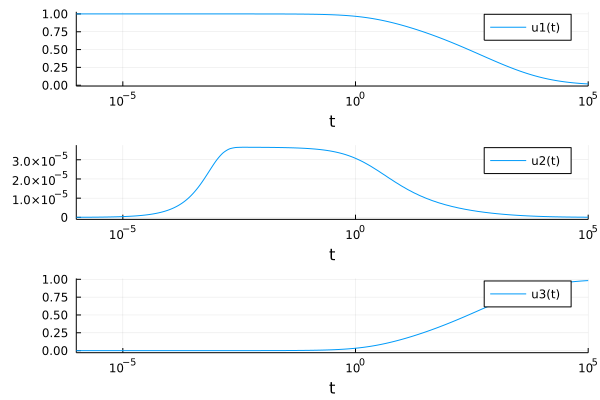

In [11]:
ode_sol_ad_jac = solve(ode_prob_ad_jac, Rosenbrock23())
plot(ode_sol_ad_jac, tspan=(1e-6,1e5), xscale=:log10, layout=(3,1))

Benchmark all three solves

In [12]:
@btime solve(ode_prob, Rosenbrock23());
@btime solve(ode_prob_jac, Rosenbrock23());
@btime solve(ode_prob_ad_jac, Rosenbrock23());

  74.263 μs (438 allocations: 38.41 KiB)
  62.635 μs (355 allocations: 32.34 KiB)
  92.727 μs (775 allocations: 70.78 KiB)


## Solve with StaticArrays

This approach can work well for small systems (< 20 ODEs)

In [13]:
using StaticArrays

function rober_sa(u, p, t)
  y₁,y₂,y₃ = u
  k₁,k₂,k₃ = p
  dy₁ = -k₁*y₁+k₃*y₂*y₃
  dy₂ =  k₁*y₁-k₂*y₂^2-k₃*y₂*y₃
  dy₃ =  k₂*y₂^2
    
  SA[dy₁, dy₂, dy₃]
end

function rober_jac_auto_sa(u,p,t)
  ForwardDiff.jacobian(x -> rober_sa(x, p, t), u)
end

rober_jac_auto_sa (generic function with 1 method)

In [14]:
ode_fun_sa = ODEFunction(rober_sa, jac=rober_jac_auto_sa, jac_prototype=StaticArray)

u₀ = SA[1.0,0.0,0.0]
ode_prob_sa = ODEProblem(ode_fun_sa, u₀,tspan,params);

In [15]:
@btime solve(ode_prob, Rosenbrock23());
@btime solve(ode_prob_jac, Rosenbrock23());
@btime solve(ode_prob_ad_jac, Rosenbrock23());
@btime solve(ode_prob_sa, Rosenbrock23());

  63.330 μs (438 allocations: 38.41 KiB)
  71.371 μs (355 allocations: 32.34 KiB)
  93.321 μs (775 allocations: 70.78 KiB)
  29.188 μs (175 allocations: 21.92 KiB)


# Mass matrix ODEs 

Normally we seek to write our ODEs in the form

$$
u' = f(u, p, t)
$$

However, sometimes it's common to have an equation in the form

$$
M u' = f(u, p, t)
$$

where $M$ is known as the *mass matrix*.  We can rewrite the Robertson equations as


\begin{align}
\frac{dy_1}{dt} &= -0.04y_1 + 10^4 y_2 y_3 \\
\frac{dy_2}{dt} &=  0.04y_1 - 10^4 y_2 y_3 - 3 * 10^7 y_2^2 \\
1 &= y_1 + y_2 + y_3
\end{align}

In [16]:
function rober_dae!(du,u,p,t)
  y₁,y₂,y₃ = u
  k₁,k₂,k₃ = p
  du[1] = -k₁*y₁ + k₃*y₂*y₃
  du[2] =  k₁*y₁ - k₃*y₂*y₃ - k₂*y₂^2
  du[3] =  y₁ + y₂ + y₃ - 1
  nothing
end

rober_dae! (generic function with 1 method)

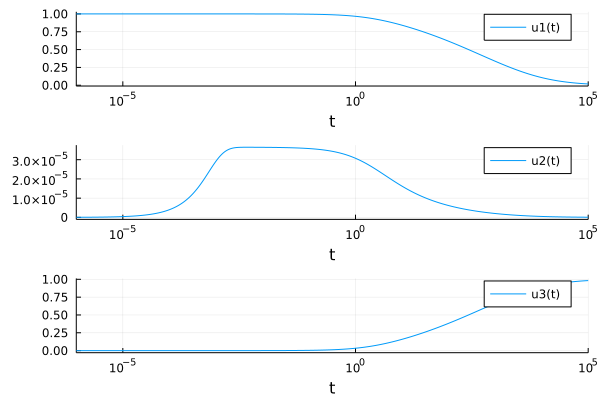

In [17]:
M = [1. 0  0
     0  1. 0
     0  0  0]

u₀ = [1.0,0.0,0.0]

ode_fun_mm = ODEFunction(rober_dae!, mass_matrix=M)
ode_prob_mm = ODEProblem(ode_fun_mm, u₀, tspan, params)

ode_sol_mm = solve(ode_prob_mm,Rodas5(),reltol=1e-8,abstol=1e-8)
plot(ode_sol_mm, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

# Implicitly defined ODEs/DAEs

In this example we'll write the Robertson equation in an implicit (also known as residual) form

$$
f(du, u, p, t) = 0
$$

Rewriting the Robertson equations in this form we have

\begin{align}
0  &= -0.04y_1 + 10^4 y_2 y_3 - \frac{dy_1}{dt} \\
0  &=  0.04y_1 - 10^4 y_2 y_3 - 3 * 10^7 y_2^2 - \frac{dy_2}{dt} \\
0 &= y_1 + y_2 + y_3 - 1
\end{align}

In [18]:
function rober_implicit_dae!(out, du, u, p, t)
  dy₁, dy₂, dy₃ = du
  y₁, y₂, y₃ = u
  k₁, k₂, k₃ = p
    
  out[1] = -k₁*y₁ + k₃*y₂*y₃ - dy₁
  out[2] =  k₁*y₁ - k₃*y₂*y₃ - k₂*y₂^2 - dy₂
  out[3] =  y₁ + y₂ + y₃ - 1
  nothing  
end

rober_implicit_dae! (generic function with 1 method)

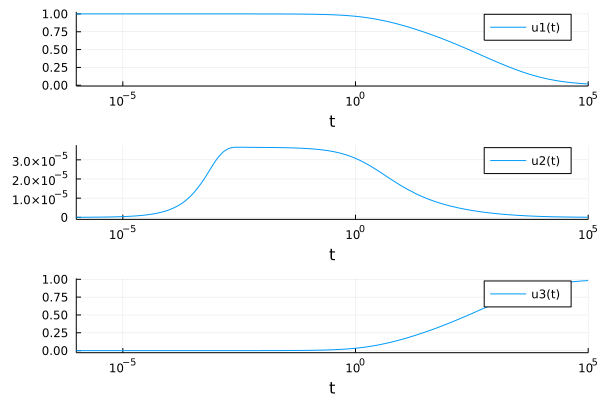

In [19]:
du₀ = [-0.04, 0.04, 0.0]

implicit_dae_prob = DAEProblem(rober_implicit_dae!, du₀, u₀,tspan, params, 
                               differential_vars=[true,true,false]);

implicit_dae_sol = solve(implicit_dae_prob)
plot(implicit_dae_sol, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

## Implicit ODE/DAE with Jacobian

The Jacobian of an implicit ODE/DAE written in the form

$$
f(d\mathbf{u}, d\mathbf{u}, p, t) = 0
$$

is

$$
J_{ij} = \gamma \frac{\partial f_i}{\partial(du)_j} + \frac{\partial f_i}{\partial u_j}
$$

where $\gamma$ is supplied by the solver.

In [20]:
function rober_implicit_dae_jacobian!(J,du,u,p,gamma,t)
  #J = gamma*df/d(du) + df/du
  dy₁, dy₂, dy₃ = du
  y₁, y₂, y₃ = u
  k₁, k₂, k₃ = p  
    
  J[1,1] = -gamma - k₁
  J[1,2] = k₃*y₃
  J[1,3] = k₃*y₂
  J[2,1] = k₁
  J[2,2] = -gamma - k₃*y₃ - 2*k₂*y₂
  J[2,3] = -k₃*y₂
  J[3,1] = 1
  J[3,2] = 1
  J[3,3] = 1
end

rober_implicit_dae_jacobian! (generic function with 1 method)

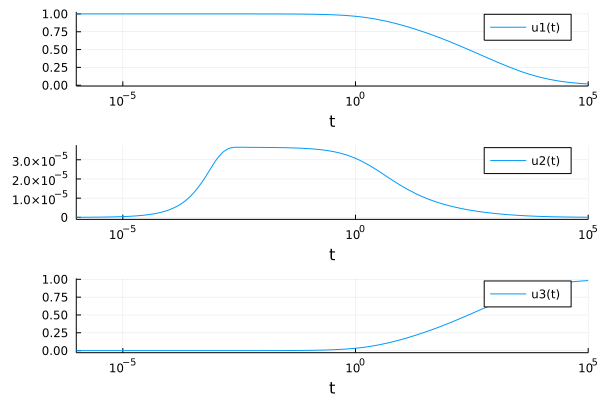

In [21]:
dae_implicit_fun_jac = DAEFunction(rober_implicit_dae!, jac=rober_implicit_dae_jacobian!)
implicit_dae_prob_jac = DAEProblem(dae_implicit_fun_jac, du₀, u₀, tspan, params, 
                                   differential_vars=[true,true,false]);
implicit_dae_sol_jac = solve(implicit_dae_prob_jac)
plot(implicit_dae_sol_jac, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

## Automatic differentiation Jacobian (StaticArrays)

In [22]:
function rober_implicit_dae(du, u, p, t)
  dy₁, dy₂, dy₃ = du
  y₁, y₂, y₃ = u
  k₁, k₂, k₃ = p
    
  SA[-k₁*y₁ + k₃*y₂*y₃ - dy₁,
     k₁*y₁ - k₃*y₂*y₃ - k₂*y₂^2 - dy₂,
     y₁ + y₂ + y₃ - 1]
end

rober_implicit_dae (generic function with 1 method)

In [23]:
function rober_implicit_dae_ad_jacobian!(J,du,u,p,gamma,t)
  #J = gamma*df/d(du) + df/du
  ForwardDiff.jacobian!(J, x -> rober_implicit_dae(x, u, p, t), du) 
  J .*= gamma
    
  J .+= ForwardDiff.jacobian(x -> rober_implicit_dae(du, x, p, t), u) 
  nothing
end

rober_implicit_dae_ad_jacobian! (generic function with 1 method)

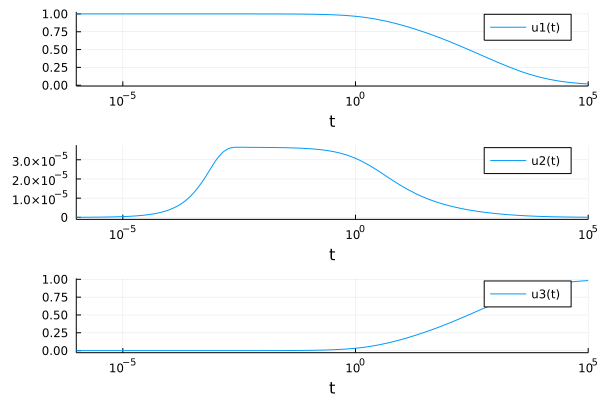

In [24]:
u₀ = SA[1.0, 0.0, 0.0]
du₀ = SA[-0.04, 0.04, 0.0]

dae_implicit_fun_ad_jac_sa = DAEFunction(rober_implicit_dae, 
                                         jac=rober_implicit_dae_ad_jacobian!,
                                         jac_prototype=StaticArray)
implicit_dae_prob_ad_jac_sa = DAEProblem(dae_implicit_fun_ad_jac_sa, du₀, u₀, tspan, params, 
                                      differential_vars=[true,true,false]);

implicit_dae_sol_ad_jac_sa = solve(implicit_dae_prob_ad_jac_sa)
plot(implicit_dae_sol_ad_jac_sa, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

Benchmarks

In [25]:
@btime solve(implicit_dae_prob)
@btime solve(implicit_dae_prob_jac);
@btime solve(implicit_dae_prob_ad_jac_sa);

  331.667 μs (3023 allocations: 116.66 KiB)
  307.957 μs (2746 allocations: 103.80 KiB)
  281.629 μs (2742 allocations: 111.36 KiB)


In [29]:
macro javascript_str(s) display("text/javascript", s); end
javascript"""
function hideElements(elements, start) {
for(var i = 0, length = elements.length; i < length;i++) {
    if(i >= start) {
        elements[i].style.display = "none";
    }
}
}
var prompt_elements = document.getElementsByClassName("prompt");
hideElements(prompt_elements, 0)
"""